In [1]:
import torch
from torch import nn
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    cohen_kappa_score,
    matthews_corrcoef,
    log_loss,
)
from torch.utils.data import Dataset, DataLoader
import os
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from collections import Counter
from tqdm.auto import tqdm
from tabulate import tabulate
from typing import Dict, List

%matplotlib inline

In [2]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
train_a = pd.read_csv("/kaggle/input/numta/training-a.csv")
train_b = pd.read_csv("/kaggle/input/numta/training-b.csv")
train_c = pd.read_csv("/kaggle/input/numta/training-c.csv")
train_d = pd.read_csv("/kaggle/input/numta/training-d.csv")
train_e = pd.read_csv("/kaggle/input/numta/training-e.csv")
train = pd.concat([train_a, train_b, train_c, train_d, train_e], ignore_index=True)
train.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


filename           original filename  scanid  digit  \
0  a00000.png   Scan_58_digit_5_num_8.png      58      5   
1  a00001.png   Scan_73_digit_3_num_5.png      73      3   
2  a00002.png   Scan_18_digit_1_num_3.png      18      1   
3  a00003.png  Scan_166_digit_7_num_3.png     166      7   
4  a00004.png  Scan_108_digit_0_num_1.png     108      0   

  database name original contributing team database name  num  districtid  \
0                  BHDDB      Buet_Broncos    training-a  NaN         NaN   
1                  BHDDB      Buet_Broncos    training-a  NaN         NaN   
2                  BHDDB      Buet_Broncos    training-a  NaN         NaN   
3                  BHDDB      Buet_Broncos    training-a  NaN         NaN   
4                  BHDDB      Buet_Broncos    training-a  NaN         NaN   

   institutionid  gender  age  datestamp  
0            NaN     NaN  NaN        NaN  
1            NaN     NaN  NaN        NaN  
2            NaN     NaN  NaN        NaN  
3            NaN     NaN  NaN        NaN  
4            NaN     NaN  NaN        NaN

In [4]:
train=train[["filename","digit"]]
train.head()

filename  digit
0  a00000.png      5
1  a00001.png      3
2  a00002.png      1
3  a00003.png      7
4  a00004.png      0

In [5]:
train.isnull().sum()

filename    0
digit       0
dtype: int64

In [6]:
train.shape

(72045, 2)

# dataset class length

In [7]:
train["digit"].value_counts()

digit
4    7252
0    7241
5    7239
3    7233
2    7224
6    7212
1    7194
7    7179
8    7158
9    7113
Name: count, dtype: int64

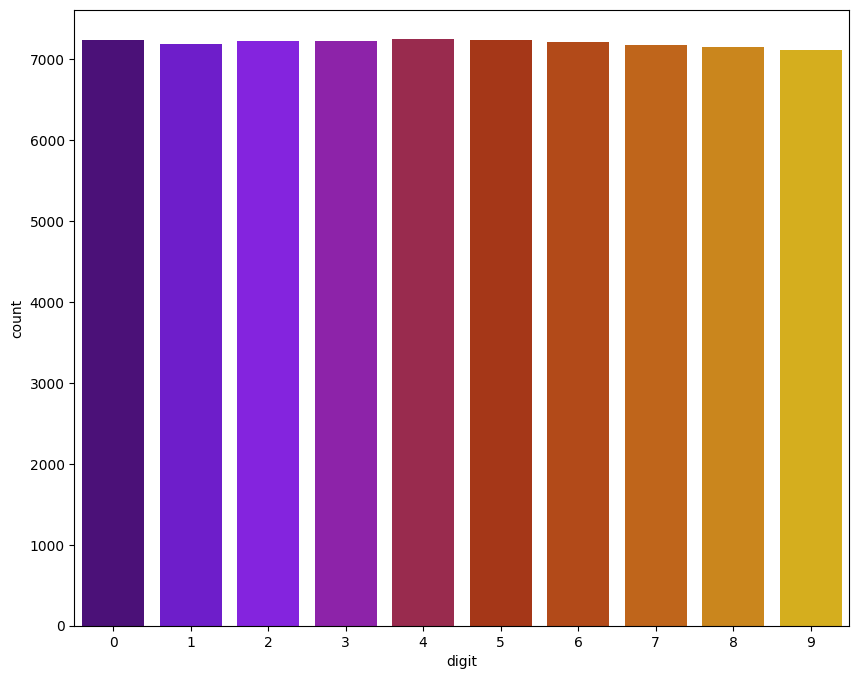

In [8]:
plt.figure(figsize=(10,8))
sns.countplot(data=train,x="digit",palette="gnuplot")
plt.show()

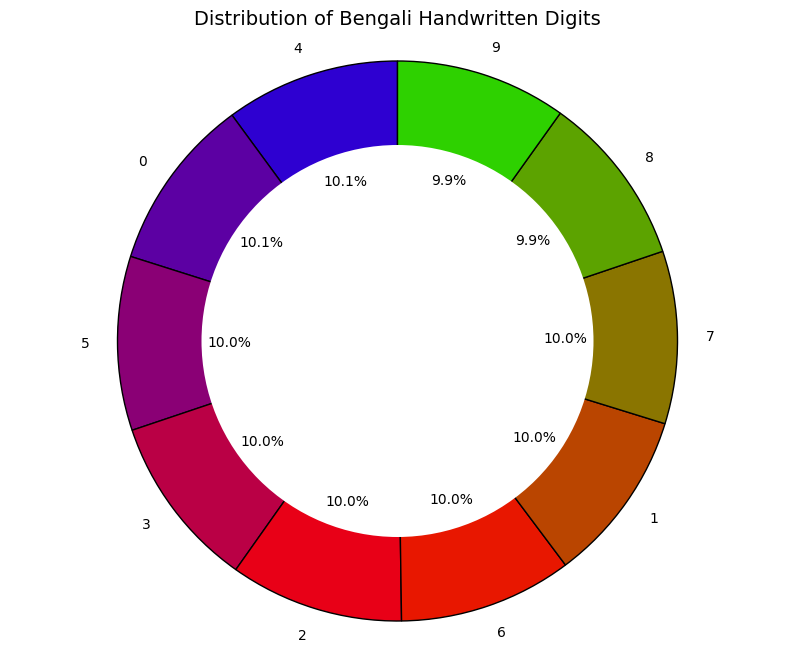

In [9]:
digit_counts = train['digit'].value_counts()

plt.figure(figsize=(10, 8))
colors = sns.color_palette("brg", len(digit_counts))
plt.pie(digit_counts, labels=digit_counts.index, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'})

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
plt.gca().add_artist(centre_circle)
plt.axis("equal")
plt.title("Distribution of Bengali Handwritten Digits", fontsize=14)
plt.show()

# Visualize images from train data

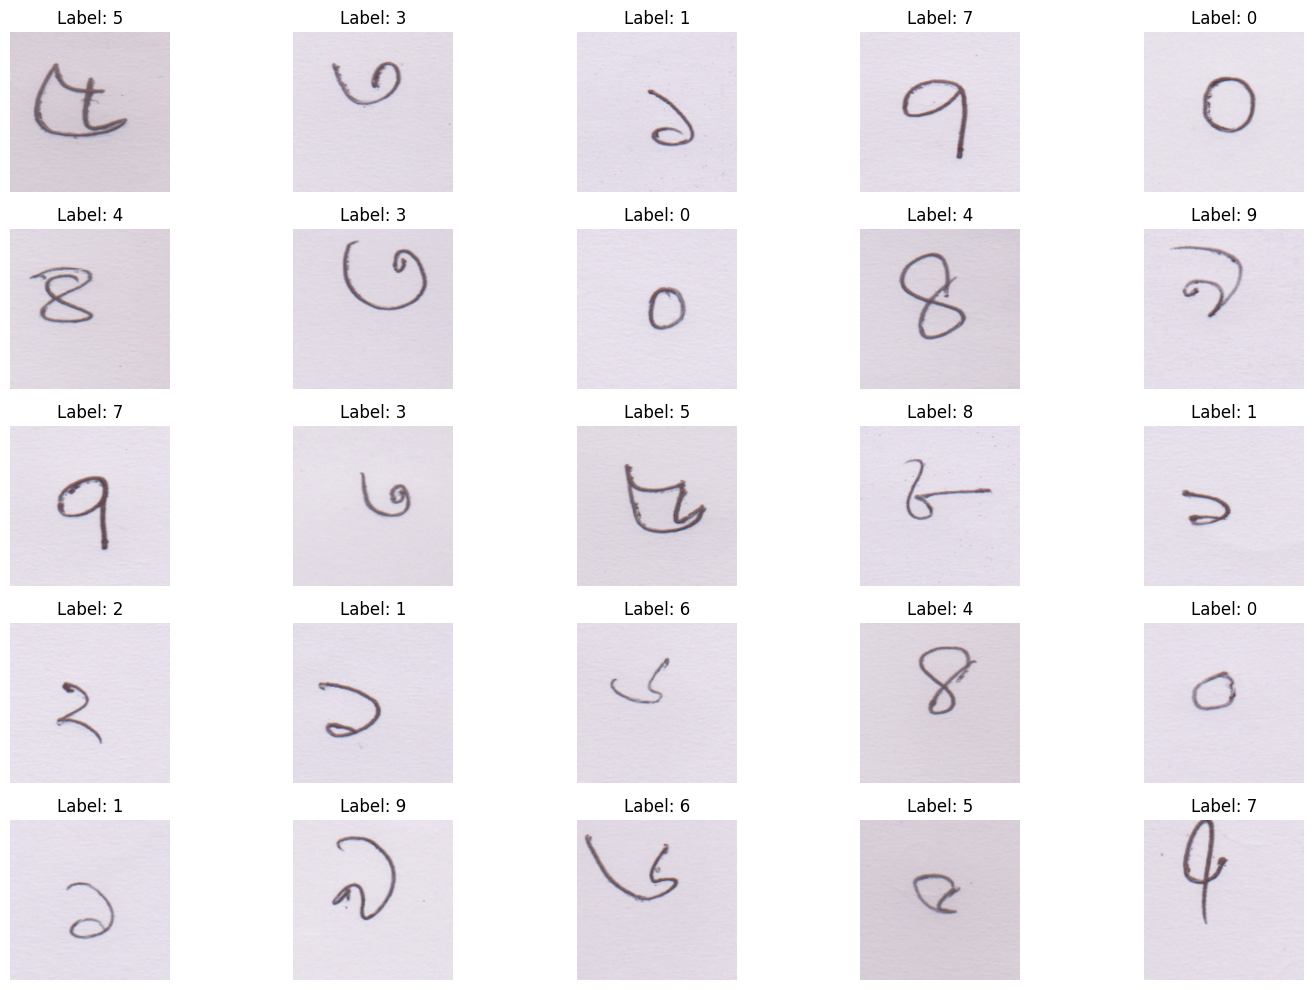

In [10]:
image_train_a="/kaggle/input/numta/training-a/"
image_train_b="/kaggle/input/numta/training-b/"
image_train_c="/kaggle/input/numta/training-c/"
image_train_d="/kaggle/input/numta/training-d/"
image_train_e="/kaggle/input/numta/training-e/"
image_train_paths=[image_train_a,image_train_b,image_train_c,image_train_d,image_train_e]

fig, axes = plt.subplots(5, 5, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    if i < len(train):
        filename = train.iloc[i]["filename"]
        label = train.iloc[i]["digit"]

        img_path = None
        for folder in image_train_paths:
            path = os.path.join(folder, filename)
            if os.path.exists(path):
                img_path = path
                break

        if img_path:
            img = Image.open(img_path)
            ax.imshow(img, cmap="gray")
            ax.set_title(f"Label: {label}")
        else:
            ax.set_title("Not Found")

    ax.axis("off")

plt.tight_layout()
plt.show()

In [11]:
image_data = []

for i, row in tqdm(train.iterrows(), total=len(train), desc="Processing Images"):
    filename = row["filename"]
    label = row["digit"]

    img_path = None
    for folder in image_train_paths:
        path = os.path.join(folder, filename)
        if os.path.exists(path):
            img_path = path
            break

    if img_path:
        img = Image.open(img_path)
        image_data.append({"image": img, "label": label})

df_images = pd.DataFrame(image_data)

Processing Images:   0%|          | 0/72045 [00:00<?, ?it/s]

In [12]:
df_images.head()

image  label
0  <PIL.PngImagePlugin.PngImageFile image mode=RG...      5
1  <PIL.PngImagePlugin.PngImageFile image mode=RG...      3
2  <PIL.PngImagePlugin.PngImageFile image mode=RG...      1
3  <PIL.PngImagePlugin.PngImageFile image mode=RG...      7
4  <PIL.PngImagePlugin.PngImageFile image mode=RG...      0

In [13]:
test_a = "/kaggle/input/numta/testing-a/"
test_b = "/kaggle/input/numta/testing-b/"
test_c = "/kaggle/input/numta/testing-c/"
test_d = "/kaggle/input/numta/testing-d/"
test_e = "/kaggle/input/numta/testing-e/"
test_a_images = [os.path.join(test_a, f) for f in os.listdir(test_a) if f.endswith('.png') or f.endswith('.jpg') or f.endswith('.jpeg')]
test_b_images = [os.path.join(test_b, f) for f in os.listdir(test_b) if f.endswith('.png') or f.endswith('.jpg') or f.endswith('.jpeg')]
test_c_images = [os.path.join(test_c, f) for f in os.listdir(test_c) if f.endswith('.png') or f.endswith('.jpg') or f.endswith('.jpeg')]
test_d_images = [os.path.join(test_d, f) for f in os.listdir(test_d) if f.endswith('.png') or f.endswith('.jpg') or f.endswith('.jpeg')]
test_e_images = [os.path.join(test_e, f) for f in os.listdir(test_e) if f.endswith('.png') or f.endswith('.jpg') or f.endswith('.jpeg')]
all_images = test_a_images + test_b_images + test_c_images + test_d_images + test_e_images
test= pd.DataFrame(all_images, columns=['imagefile'])
test.head()

imagefile
0  /kaggle/input/numta/testing-a/a01683.png
1  /kaggle/input/numta/testing-a/a01460.png
2  /kaggle/input/numta/testing-a/a01920.png
3  /kaggle/input/numta/testing-a/a00737.png
4  /kaggle/input/numta/testing-a/a00446.png

In [14]:
test.shape

(12857, 1)

In [15]:
test.isnull().sum()

imagefile    0
dtype: int64

# visualize images from test data

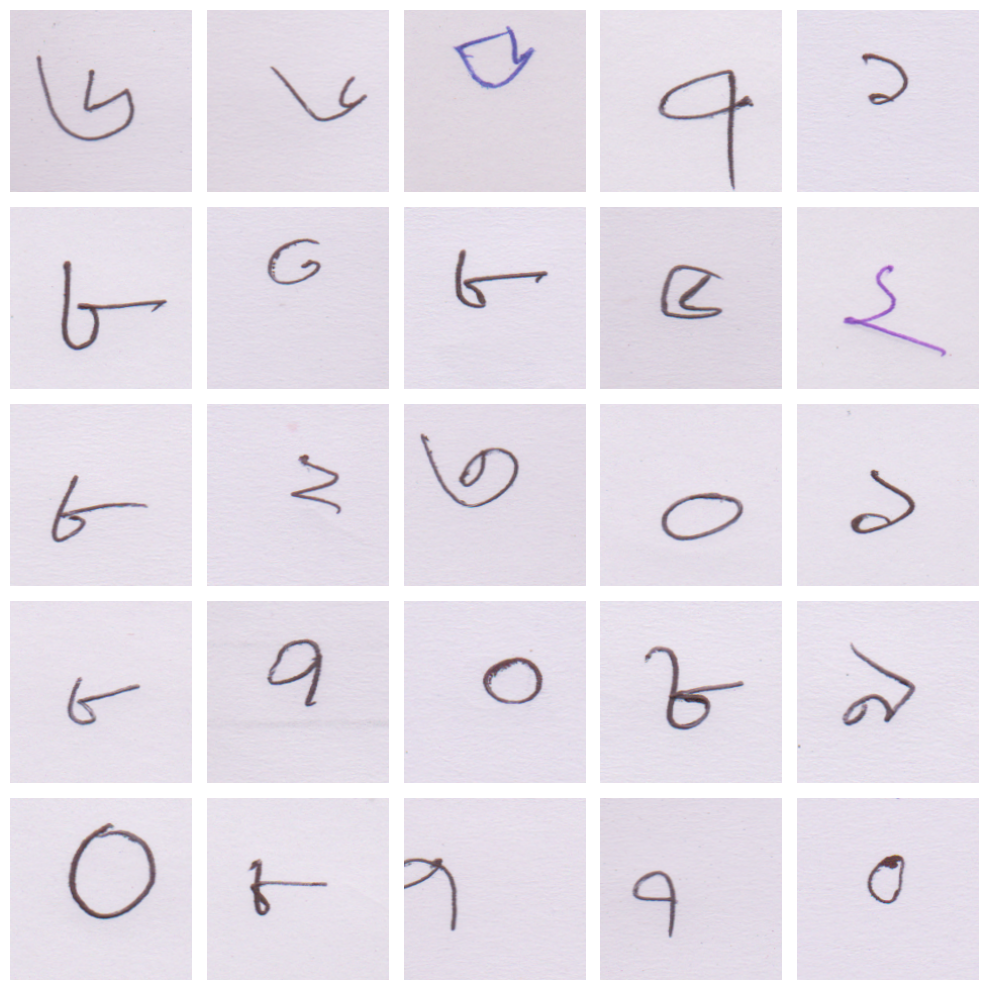

In [16]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    if i < len(test):
        img_path = test.iloc[i]["imagefile"]
        img = Image.open(img_path)
        ax.imshow(img, cmap="gray")
    
    ax.axis("off")

plt.tight_layout()
plt.show()

# transform Images

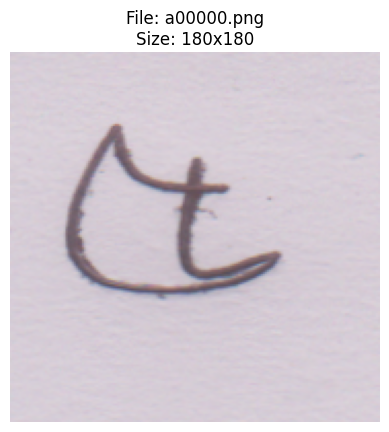

In [17]:
test_image = df_images["image"][0]
file_name = train.iloc[0]["filename"]  # Access the filename from the original DataFrame
image_size = test_image.size  # Get the image size (width, height)

plt.imshow(test_image)
plt.title(f"File: {file_name}\nSize: {image_size[0]}x{image_size[1]}")
plt.axis('off')
plt.show()


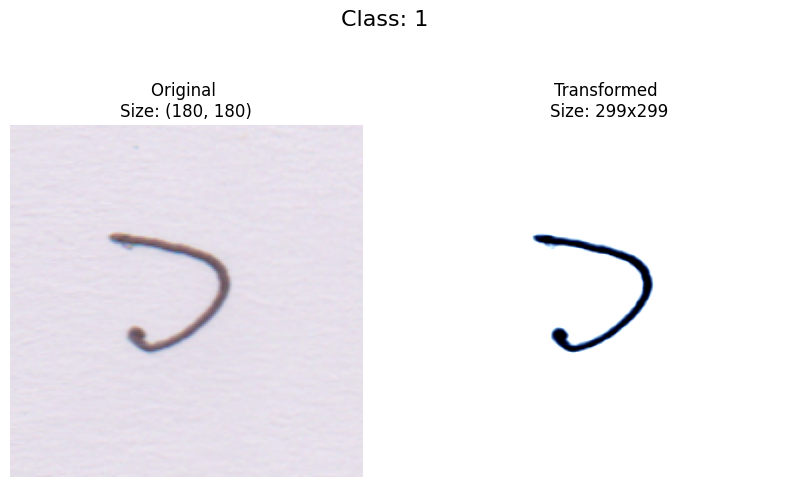

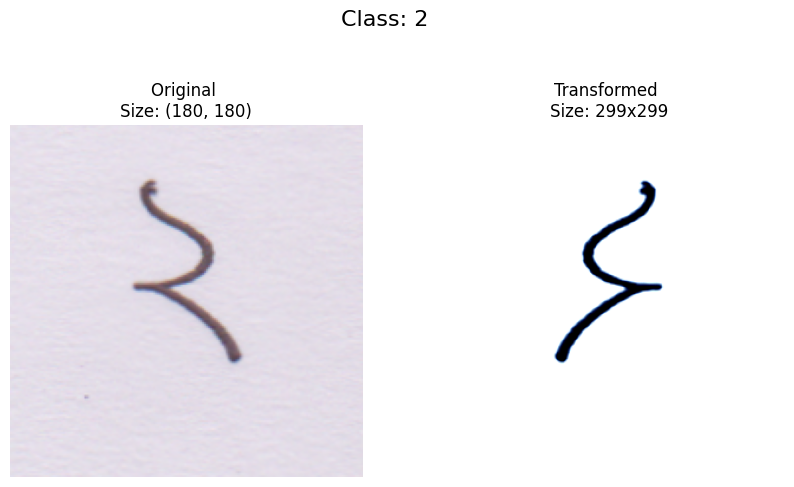

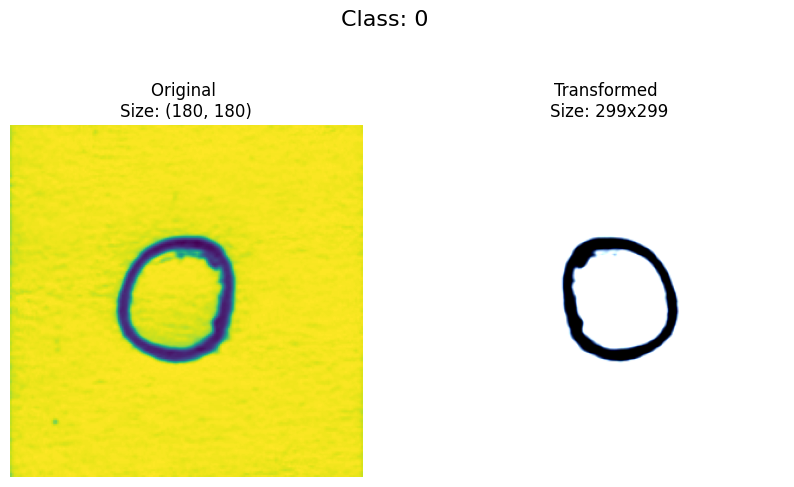

In [18]:

data_transform = transforms.Compose([
    transforms.Resize(size=(299, 299)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def plot_transformed_images_from_df(df_images, transform, n=3, seed=42):
    random.seed(seed)
    random_images = random.sample(range(len(df_images)), k=n)
    
    for idx in random_images:
        image = df_images.iloc[idx]["image"]
        label = df_images.iloc[idx]["label"]

        fig, ax = plt.subplots(1, 2, figsize=(10, 6))
        
        # Original image
        ax[0].imshow(image)
        ax[0].set_title(f"Original \nSize: {image.size}")
        ax[0].axis("off")

        # Transformed image
        transformed_image = transform(image).permute(1, 2, 0)
        ax[1].imshow(transformed_image)
        ax[1].set_title(f"Transformed \nSize: {transformed_image.shape[1]}x{transformed_image.shape[0]}")
        ax[1].axis("off")

        fig.suptitle(f"Class: {label}", fontsize=16)


plot_transformed_images_from_df(df_images, transform=data_transform, n=3)


# split the dataset

In [19]:
from sklearn.model_selection import train_test_split


train_df, valid_df = train_test_split(df_images, test_size=0.2, random_state=42)

# Display the number of samples in each set
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(valid_df)}")


Training set size: 57636
Validation set size: 14409


In [20]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.dataframe.iloc[idx]["image"]
        label = self.dataframe.iloc[idx]["label"]
        
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label,dtype=torch.long)

train_dataset = ImageDataset(dataframe=train_df, transform=data_transform)
valid_dataset = ImageDataset(dataframe=valid_df, transform=data_transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False,drop_last=True)

In [21]:
for images, labels in train_loader:
    print(f"Batch images shape: {images.shape}")
    print(f"Batch labels: {labels}")
    break

Batch images shape: torch.Size([16, 3, 299, 299])
Batch labels: tensor([3, 4, 3, 2, 6, 9, 2, 2, 4, 2, 6, 7, 7, 0, 0, 0])


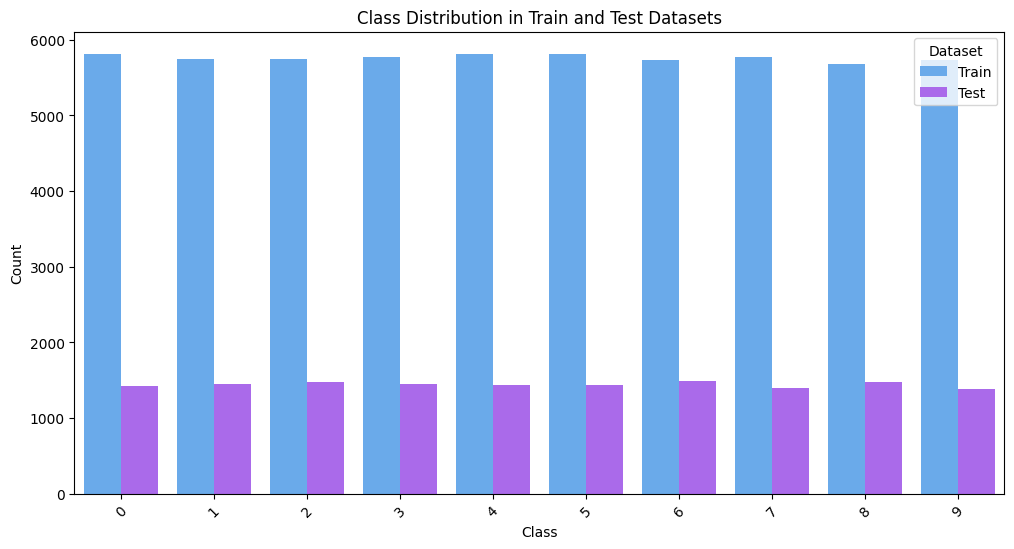

In [22]:
def get_labels(dataloader):
    labels = []
    for _, label in dataloader:
        labels.extend(label.numpy())
    return labels

train_labels = get_labels(train_loader)
test_labels = get_labels(valid_loader)

train_class_counts = Counter(train_labels)
test_class_counts = Counter(test_labels)

train_df = pd.DataFrame(train_class_counts.items(), columns=['Class', 'Count'])
test_df = pd.DataFrame(test_class_counts.items(), columns=['Class', 'Count'])

train_df['Dataset'] = 'Train'
test_df['Dataset'] = 'Test'

combined_df = pd.concat([train_df, test_df])

plt.figure(figsize=(12, 6))
sns.barplot(data=combined_df, x='Class', y='Count', hue='Dataset', palette='cool')
plt.title('Class Distribution in Train and Test Datasets')
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend(title='Dataset')
plt.xticks(rotation=45)
plt.show()

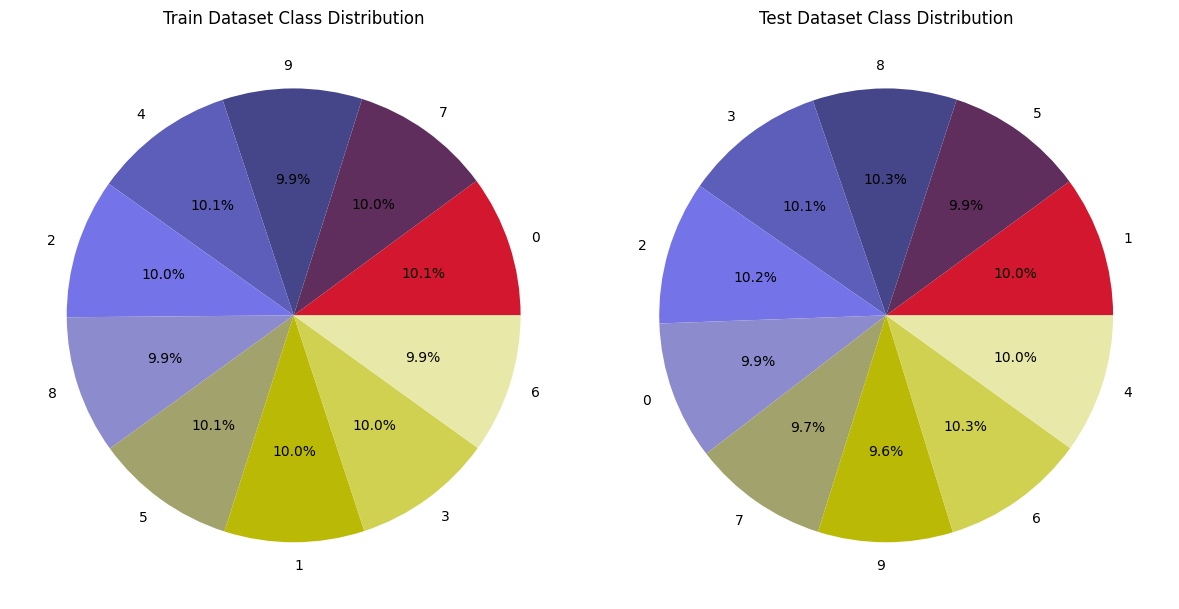

In [23]:
train_labels = get_labels(train_loader)
test_labels = get_labels(valid_loader)

train_class_counts = Counter(train_labels)
test_class_counts = Counter(test_labels)

train_df = pd.DataFrame(train_class_counts.items(), columns=['Class', 'Count'])
test_df = pd.DataFrame(test_class_counts.items(), columns=['Class', 'Count'])

train_df['Dataset'] = 'Train'
test_df['Dataset'] = 'Test'

combined_df = pd.concat([train_df, test_df])

# Plotting Pie Charts
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
colors = sns.color_palette("gist_stern", len(digit_counts))
axes[0].pie(train_df['Count'], labels=train_df['Class'], autopct='%1.1f%%', colors=colors)
axes[0].set_title('Train Dataset Class Distribution')

axes[1].pie(test_df['Count'], labels=test_df['Class'], autopct='%1.1f%%', colors=colors)
axes[1].set_title('Test Dataset Class Distribution')

plt.tight_layout()
plt.show()


# Create Model

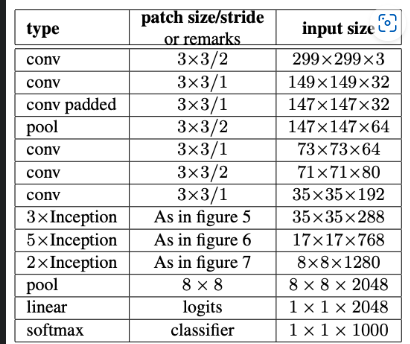

## Model Description

Inception v3: Based on the exploration of ways to scale up networks in ways that aim at utilizing the added computation as efficiently as possible by suitably factorized convolutions and aggressive regularization. We benchmark our methods on the ILSVRC 2012 classification challenge validation set demonstrate substantial gains over the state of the art: 21.2% top-1 and 5.6% top-5 error for single frame evaluation using a network with a computational cost of 5 billion multiply-adds per inference and with using less than 25 million parameters. With an ensemble of 4 models and multi-crop evaluation, we report 3.5% top-5 error on the validation set (3.6% error on the test set) and 17.3% top-1 error on the validation set.

[Rethinking the Inception Architecture for Computer Vision](https://arxiv.org/abs/1512.00567)

In [24]:


model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
n_classes = len(train_df['Class'].unique())
model.fc = nn.Linear(model.fc.in_features, n_classes)
model = model.to(device)
from torchinfo import summary
summary(model, input_size=[16, 3,299,299])

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
Inception3                               [16, 10]                  3,326,696
├─BasicConv2d: 1-1                       [16, 32, 149, 149]        --
│    └─Conv2d: 2-1                       [16, 32, 149, 149]        864
│    └─BatchNorm2d: 2-2                  [16, 32, 149, 149]        64
├─BasicConv2d: 1-2                       [16, 32, 147, 147]        --
│    └─Conv2d: 2-3                       [16, 32, 147, 147]        9,216
│    └─BatchNorm2d: 2-4                  [16, 32, 147, 147]        64
├─BasicConv2d: 1-3                       [16, 64, 147, 147]        --
│    └─Conv2d: 2-5                       [16, 64, 147, 147]        18,432
│    └─BatchNorm2d: 2-6                  [16, 64, 147, 147]        128
├─MaxPool2d: 1-4                         [16, 64, 73, 73]          --
├─BasicConv2d: 1-5                       [16, 80, 73, 73]          --
│    └─Conv2d: 2-7                       [16, 80, 73, 73]          5,

# Create train & test loop functions

In [25]:


def train_step(model, dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss, train_acc = 0, 0
    pbar = tqdm(dataloader, desc="Train")
    for X, y in pbar:
        X, y = X.to(device), y.to(device)
        output = model(X)
        y_pred = output.logits if hasattr(output, "logits") else output
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(y_pred, dim=1)
        train_acc += (y_pred_class == y).sum().item() / y.size(0)
        pbar.set_postfix(loss=f"{loss.item():.4f}")
    return train_loss / len(dataloader), train_acc / len(dataloader)



In [26]:

def valid_step(model, dataloader, loss_fn, device):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        pbar = tqdm(dataloader, desc="Valid")
        for X, y in pbar:
            X, y = X.to(device), y.to(device)
            output = model(X)
            test_pred_logits = output.logits if hasattr(output, "logits") else output
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item() / y.size(0))
            pbar.set_postfix(loss=f"{loss.item():.4f}")
    return test_loss / len(dataloader), test_acc / len(dataloader)

In [27]:
def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    print(f"Model running on: {device}")
    
    for epoch in tqdm(range(epochs), desc="Epochs"):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
        test_loss, test_acc = valid_step(model, test_dataloader, loss_fn, device)
        
        # Store results
        metrics = [train_loss, train_acc, test_loss, test_acc]
        for k, v in zip(results.keys(), metrics):
            results[k].append(float(v))
        
        # Create table for current epoch
        headers = ["Epoch", "Train Loss", "Train Accuracy", "Validation Loss", "Validation Accuracy"]
        table_data = [[
            f"{epoch+1}/{epochs}",
            f"{train_loss:.4f}",
            f"{train_acc:.4%}",
            f"{test_loss:.4f}",
            f"{test_acc:.4%}"
        ]]
        print("\n" + tabulate(table_data, headers=headers, tablefmt="grid"))
    
    return results

# Training setup and execution

In [28]:

NUM_EPOCHS = 5
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

history = train(
    model=model,
    train_dataloader=train_loader,
    test_dataloader=valid_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS
)

Model running on: cuda


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Train:   0%|          | 0/3602 [00:00<?, ?it/s]

Valid:   0%|          | 0/900 [00:00<?, ?it/s]


+---------+--------------+------------------+-------------------+-----------------------+
| Epoch   |   Train Loss | Train Accuracy   |   Validation Loss | Validation Accuracy   |
+=========+==============+==================+===================+=======================+
| 1/5     |       0.1418 | 96.1219%         |            0.0583 | 98.2986%              |
+---------+--------------+------------------+-------------------+-----------------------+


Train:   0%|          | 0/3602 [00:00<?, ?it/s]

Valid:   0%|          | 0/900 [00:00<?, ?it/s]


+---------+--------------+------------------+-------------------+-----------------------+
| Epoch   |   Train Loss | Train Accuracy   |   Validation Loss | Validation Accuracy   |
+=========+==============+==================+===================+=======================+
| 2/5     |       0.0584 | 98.4332%         |            0.0498 | 98.6528%              |
+---------+--------------+------------------+-------------------+-----------------------+


Train:   0%|          | 0/3602 [00:00<?, ?it/s]

Valid:   0%|          | 0/900 [00:00<?, ?it/s]


+---------+--------------+------------------+-------------------+-----------------------+
| Epoch   |   Train Loss | Train Accuracy   |   Validation Loss | Validation Accuracy   |
+=========+==============+==================+===================+=======================+
| 3/5     |       0.0446 | 98.7628%         |            0.0404 | 98.9722%              |
+---------+--------------+------------------+-------------------+-----------------------+


Train:   0%|          | 0/3602 [00:00<?, ?it/s]

Valid:   0%|          | 0/900 [00:00<?, ?it/s]


+---------+--------------+------------------+-------------------+-----------------------+
| Epoch   |   Train Loss | Train Accuracy   |   Validation Loss | Validation Accuracy   |
+=========+==============+==================+===================+=======================+
| 4/5     |       0.0358 | 99.0162%         |            0.0406 | 98.9444%              |
+---------+--------------+------------------+-------------------+-----------------------+


Train:   0%|          | 0/3602 [00:00<?, ?it/s]

Valid:   0%|          | 0/900 [00:00<?, ?it/s]


+---------+--------------+------------------+-------------------+-----------------------+
| Epoch   |   Train Loss | Train Accuracy   |   Validation Loss | Validation Accuracy   |
+=========+==============+==================+===================+=======================+
| 5/5     |       0.0339 | 99.0561%         |            0.0414 | 98.8681%              |
+---------+--------------+------------------+-------------------+-----------------------+


# Loss & Accuracy Graph

In [29]:


def plot_loss_curves(results: Dict[str, List[float]]):
    loss = results['train_loss']
    test_loss = results['test_loss']
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']
    epochs = range(len(results['train_loss']))
    
    plt.figure(figsize=(16, 8))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Training Loss', color='tab:blue', linewidth=2)
    plt.plot(epochs, test_loss, label='Validation Loss', color='tab:orange', linestyle='--', linewidth=2)
    plt.title('Loss vs Epochs', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(loc='upper right', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='Training Accuracy', color='tab:green', linewidth=2)
    plt.plot(epochs, test_accuracy, label='Validation Accuracy', color='tab:red', linestyle='--', linewidth=2)
    plt.title('Accuracy vs Epochs', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()


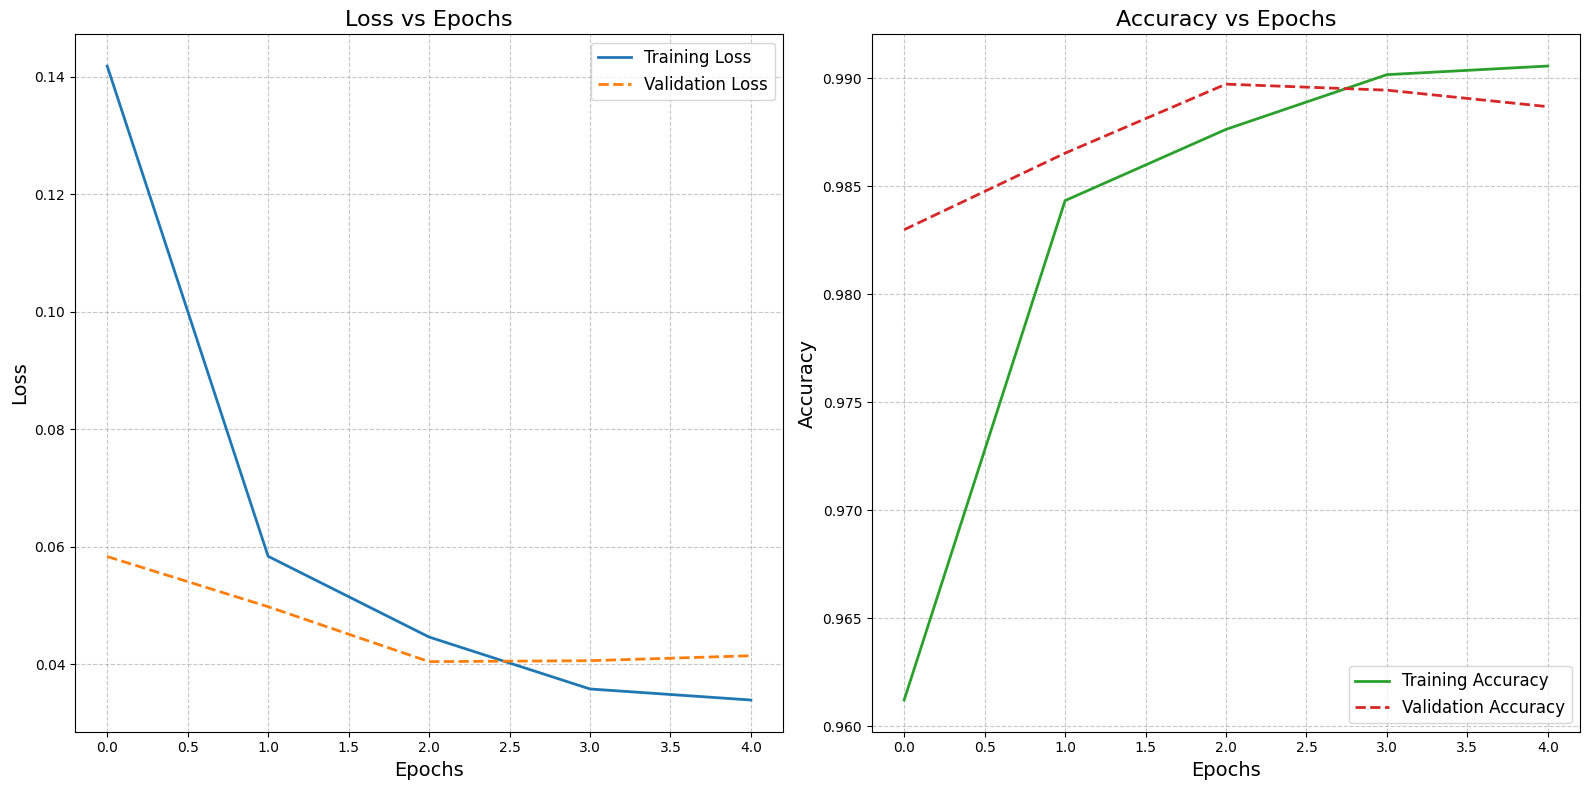

In [30]:
plot_loss_curves(history)

# Model Prediction

In [31]:

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(valid_loader, desc="Validating"):
        # Move to device
        images = images.to(device)
        labels = labels.to(device)
        
        # Get predictions
        outputs = model(images)
        pred_labels = outputs.argmax(dim=1)
        
        # Store predictions and true labels
        all_preds.extend(pred_labels.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate accuracy
print("==================================================================================================")
accuracy = (all_preds == all_labels).mean()
print(f"Validation Accuracy: {accuracy:.4f}")



Validating:   0%|          | 0/900 [00:00<?, ?it/s]

Validation Accuracy: 0.9892



# Confusion Matrix

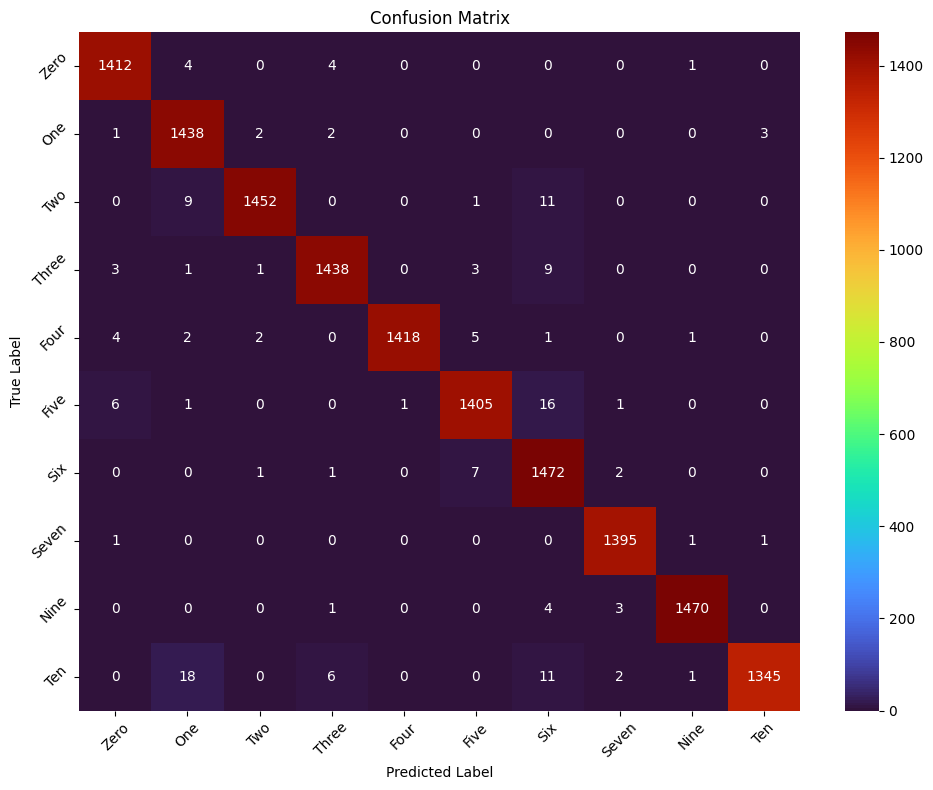

In [32]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
label_name=["Zero","One","Two","Three","Four","Five","Six","Seven","Nine","Ten"]
sns.heatmap(cm, annot=True, fmt='d',cmap='turbo',xticklabels=label_name,yticklabels=label_name)

plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


# Detailed Classification Report

In [33]:
print("\nDetailed Classification Report:")
print("#" * 60)
report = classification_report(all_labels, all_preds,target_names=label_name,digits=4)
print(report)



Detailed Classification Report:
############################################################
              precision    recall  f1-score   support

        Zero     0.9895    0.9937    0.9916      1421
         One     0.9762    0.9945    0.9853      1446
         Two     0.9959    0.9857    0.9908      1473
       Three     0.9904    0.9883    0.9893      1455
        Four     0.9993    0.9895    0.9944      1433
        Five     0.9887    0.9825    0.9856      1430
         Six     0.9659    0.9926    0.9790      1483
       Seven     0.9943    0.9979    0.9961      1398
        Nine     0.9973    0.9946    0.9959      1478
         Ten     0.9970    0.9725    0.9846      1383

    accuracy                         0.9892     14400
   macro avg     0.9895    0.9892    0.9893     14400
weighted avg     0.9894    0.9892    0.9893     14400



# Roc Curve For Each Class

Validating:   0%|          | 0/900 [00:00<?, ?it/s]

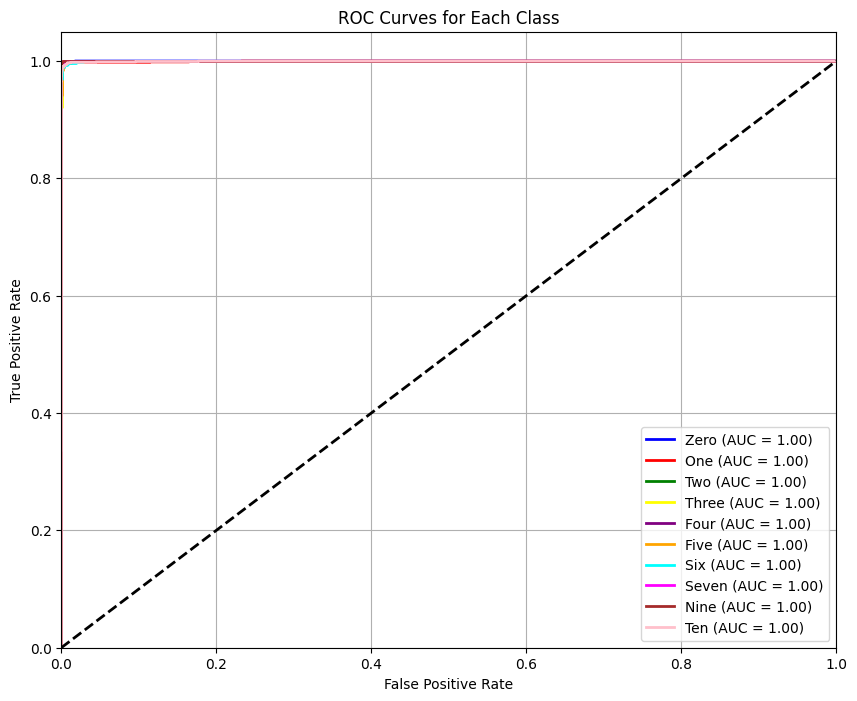

In [34]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

model.eval()
all_preds_prob = []
all_labels = []

with torch.no_grad():
   for images, labels in tqdm(valid_loader, desc="Validating"):
       images = images.to(device)
       labels = labels.to(device)
       outputs = model(images)
       probs = torch.softmax(outputs, dim=1)
       all_preds_prob.extend(probs.cpu().numpy())
       all_labels.extend(labels.cpu().numpy())

all_preds_prob = np.array(all_preds_prob)
all_labels = np.array(all_labels)

fpr = {}
tpr = {}
roc_auc = {}

n_classes = len(label_name)

for i in range(n_classes):
   fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_preds_prob[:, i])
   roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'yellow', 'purple', 'orange', 'cyan', 'magenta', 'brown', 'pink'])

for i, color in zip(range(n_classes), colors):
   plt.plot(fpr[i], tpr[i], color=color, lw=2,label=f'{label_name[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Precision Recalll Curve for Each class

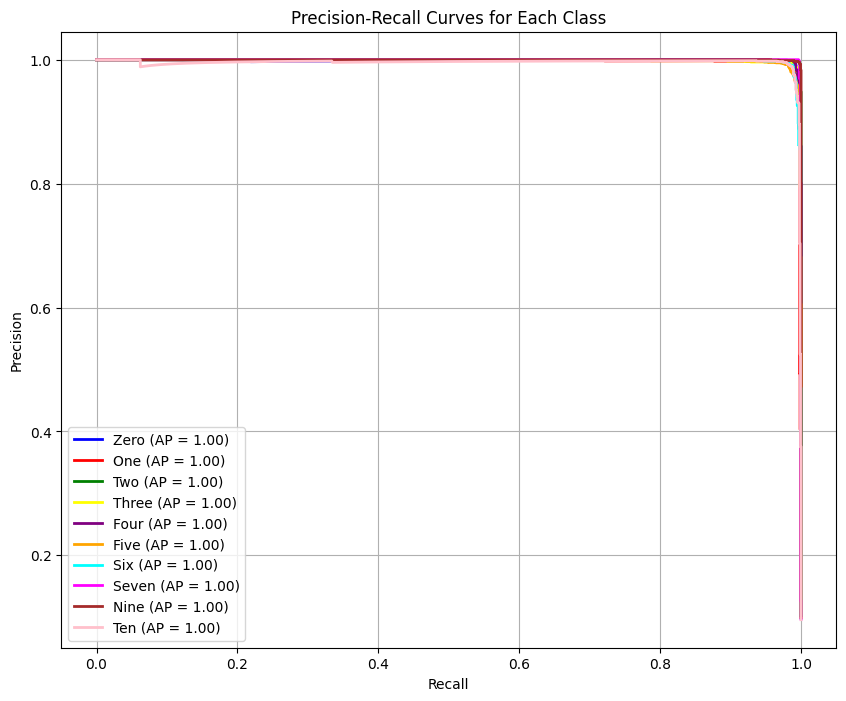

In [35]:
from sklearn.metrics import precision_recall_curve, average_precision_score
precision = {}
recall = {}
avg_precision = {}

n_classes = len(label_name)

plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'yellow', 'purple', 'orange', 'cyan', 'magenta', 'brown', 'pink'])

for i, color in zip(range(n_classes), colors):
   precision[i], recall[i], _ = precision_recall_curve(all_labels == i, all_preds_prob[:, i])
   avg_precision[i] = average_precision_score(all_labels == i, all_preds_prob[:, i])
   
   plt.plot(recall[i], precision[i], color=color, lw=2,
            label=f'{label_name[i]} (AP = {avg_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Each Class')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# Save Model

In [36]:
import os
model_dir="/kaggle/working/My_Model"
os.makedirs(model_dir,exist_ok=True)
torch.save(model.state_dict(), '/kaggle/working/My_Model/NumtaDB_Classifier_Model.pth')
print("Model saved successfully!")

Model saved successfully!


In [37]:
model.load_state_dict(torch.load("/kaggle/working/My_Model/NumtaDB_Classifier_Model.pth"))
model.eval()

<ipython-input-37-9455e56a4ce7>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/My_Model/NumtaDB_Classifier_Model.pth"))


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

# Create Gradio App

In [38]:
! pip install gradio

In [39]:
import gradio as gr
import torch
import torchvision.transforms as transforms
from PIL import Image

# Load model
model.load_state_dict(torch.load("/kaggle/working/My_Model/NumtaDB_Classifier_Model.pth"))
model.eval()

# Define preprocessing transform
transform = transforms.Compose([
   transforms.Resize(size=(299, 299)),
   transforms.Grayscale(num_output_channels=3),
   transforms.ToTensor(),
   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def predict(image):
   # Convert to PIL Image if needed
   if not isinstance(image, Image.Image):
       image = Image.fromarray(image)
   
   # Preprocess image
   image_tensor = transform(image).unsqueeze(0).to(device)
   
   # Get predictions
   with torch.no_grad():
       outputs = model(image_tensor)
       probs = torch.softmax(outputs, dim=1)
       
   # Convert predictions to dictionary
   predictions = {label_name[i]: float(probs[0][i]) for i in range(len(label_name))}
   
   return predictions

# Create Gradio interface
iface = gr.Interface(
   fn=predict,
   inputs=gr.Image(label="Upload Image"),
   outputs=gr.Label(num_top_classes=len(label_name)),
   title="BanglaDigitPro: Advanced Bengali Numeral Recognition",
   description="Upload an image of a handwritten digit to classify it.",
   examples=[
       ["/kaggle/input/numta/testing-all-corrected/testing-e/e00000.png"],
       ["/kaggle/input/numta/testing-all-corrected/testing-e/e00001.png"],
       ["/kaggle/input/numta/testing-all-corrected/testing-c/c00000.png"]
   ]
)

# Launch app
iface.launch(share=True)

<ipython-input-39-e8796637d670>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/My_Model/NumtaDB_Classifier_Model.pth"))


* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://0d89018c22e5cc9ba9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/routes.py", line 993, in predict
    output = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 2051, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1598, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 807, in run
